In [1]:
# Working with AIA, XRT and NuSTAR data in python to get the DEM via regularisation

# Now looking at some of the 28 Sep 2018 data
# 17-06-2021 IGH -> Based off axn_sep2020_new

In [2]:
# Import some of the stuff we might need

# This needs nustar_pysolar to be installed https://github.com/NuSTAR/nustar_pysolar
import nustar_pysolar as nustar

# This is from nustar_sac https://github.com/ianan/nustar_sac/blob/master/python/ns_tresp.py
import ns_tresp

#  Using demreg from https://github.com/ianan/demreg/tree/master/python
from dn2dem_pos import dn2dem_pos

# Need aiapy to be installed https://gitlab.com/LMSAL_HUB/aia_hub/aiapy
from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from pylab import figure, cm
import scipy.io as io
import glob
import astropy.time
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

---
#### Now for the XRT stuff

In [3]:
# Load in the XRT data and grade map for the Sep 2018 data from sswidl make_xrt_for_python.pro
fdata='XRT_20180928_204303_Be_thin_Open_512.fits'
xmap=sunpy.map.Map(fdata)

#  Get the XRT for just the region of interest
bl=[-310*u.arcsec, -300*u.arcsec]
tr=[-260*u.arcsec, -250*u.arcsec]
bottom_left = SkyCoord(bl[0],bl[1], frame = xmap.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=xmap.coordinate_frame)
regxmap = xmap.submap(bottom_left=bottom_left, top_right=top_right)

In [4]:
#  What is the DN/s/px from the region???
dur=regxmap.exposure_time.value
# What pixel binning per dimension
chipsum=regxmap.meta['chip_sum']
#  Get a DN/s/px (non-binned pixels) for the region
xdnspx=np.mean(regxmap.data)/dur/chipsum**2
print(xdnspx, ' DN/s/px')

1.9605031779332698  DN/s/px


In [5]:
#  Load in the XRT ones from sswidl make_xrt_tresp_forpy.pro
tr_sep20=io.readsav('xrt_tresp_20180928.dat')

filters=np.array(tr_sep20['filters'])
filters[0]=filters[0].decode('utf-8')
filters[1]=filters[1].decode('utf-8')
units=tr_sep20['units'].decode('utf-8')

---
#### Now for the AIA stuff

In [6]:
ffp=sorted(glob.glob('maps_prep_092018*.fits'))
aprep=sunpy.map.Map(ffp)

In [7]:
# Get the durations for the DN/px/s normalisation and
# wavenlength to check the order - should already be sorted above
wvn = [m.meta['wavelnth'] for m in aprep]
durs = [m.meta['exptime'] for m in aprep]
# Convert to numpy arrays as make things easier later
durs=np.array(durs)
wvn=np.array(wvn)
print(durs)
print(wvn)

[2.902056 2.901323 2.000159 2.000051 2.900769 2.900805]
[ 94 131 171 193 211 335]


In [8]:
# Use the XRT region from above
# This is just a rough example so will need to refine these - got the correct AIA feature?
bl=[-285*u.arcsec, -280*u.arcsec]
tr=[-235*u.arcsec, -230*u.arcsec]

area=(tr[0].value-bl[0].value)*(tr[1].value-bl[1].value)*7.25e7*7.25e7  
print(area)

data_mean = []
num_pix = []
for m in aprep:
    bottom_left = SkyCoord(bl[0],bl[1], frame = m.coordinate_frame)
    top_right = SkyCoord(tr[0],tr[1], frame=m.coordinate_frame)
    sub_temp = m.submap(bottom_left=bottom_left, top_right=top_right)
    data_mean.append(np.mean(sub_temp.data))
    num_pix.append(sub_temp.data.size)
#     sub_temp.plot()
#     plt.show()
print(data_mean)

1.3140625e+19
[3.8376477, 14.154058955276552, 282.08898645868237, 613.794473111726, 274.02673829542675, 3.956252477269253]


In [9]:
# Let's get the degradation correction factors
channels = [94,131,171,193,211,335] * u.angstrom
time=astropy.time.Time('2018-09-28T20:43:00', scale='utc')

# nc=len(channels)
# degs=np.empty(nc)
# for i in np.arange(nc):
#       degs[i]=degradation(channels[i],time)#,calibration_version=10)
# print(degs)

# # As slow to compute here's the previously calculated for the above
degs=np.array([0.90317732, 0.51622918, 0.73993289, 0.62176348, 0.58117789, 0.19292336])
print(degs)

[0.90317732 0.51622918 0.73993289 0.62176348 0.58117789 0.19292336]


In [10]:
#  Correct the AIA data for the degradation
cor_data=data_mean/degs
print(data_mean)
print(cor_data)

# Get into DN/s/px for the DEM stuff
adn_in=cor_data/durs
print('DN/s/px: ',adn_in)

[3.8376477, 14.154058955276552, 282.08898645868237, 613.794473111726, 274.02673829542675, 3.956252477269253]
[  4.24905231  27.41816911 381.23590703 987.18321815 471.50234551
  20.50686074]
DN/s/px:  [  1.46415242   9.45022981 190.60280059 493.57902281 162.54391353
   7.06936893]


In [11]:
#  Load in the AIA responses from sswidl make_aiaresp_forpy.pro
trin=io.readsav('aia_tresp_en.dat')

for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
# print(trin['channels'])
chans=np.array(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,7))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

---
#### Combine the XRT and AIA together

In [12]:
#  Now combine the AIA and XRT data together
dn_in=np.append(adn_in,xdnspx)
# Lets just assume 20% error
edn_in=0.2*np.copy(dn_in)
chanax=np.append(chans,filters[1])

for i in np.arange(len(dn_in)):
    print(chanax[i],': ',dn_in[i],edn_in[i])

xtrint=10**np.interp(tresp_logt,tr_sep20['logt'],np.log10(tr_sep20['tr'][1]))
trmatrix[:,6]=xtrint


A94 :  1.4641524176067948 0.292830483521359
A131 :  9.450229811411175 1.890045962282235
A171 :  190.60280059113882 38.120560118227765
A193 :  493.5790228076529 98.71580456153059
A211 :  162.5439135323166 32.50878270646332
A335 :  7.069368930806743 1.4138737861613486
Be-thin :  1.9605031779332698 0.392100635586654


---
#### Now for the NuSTAR stuff

In [13]:
# For test just using Sarah's pha,arf,rmf for FPMB and 20:39 to 20:45 -> though other options available
# Load in the pha, arf and rmf
# Using examples from https://github.com/KriSun95/krispy/blob/master/krispy/nu_spec.py
mdir='sarah_erf/'
fnsid='nu90410218001A06'

e_lo, e_hi, eff_area = ns_tresp.read_arf(mdir+fnsid+'_sr.arf')
e_lo, e_hi, rmf_mat = ns_tresp.read_rmf(mdir+fnsid+'_sr.rmf')

In [14]:
# Load in the saved output from f_vth()
# dlogT = 0.05 and dE = 0.04 keV 
#So binning size is the same as in AIA 0.05 
fvth=io.readsav('fvth_out.dat')
engs=fvth['eng']
de=engs[1]-engs[0]
logt=fvth['logt']
phmod=np.array(fvth['fvth']) # in units of photons/s/keV/cm2

nume=len(engs)
arf=eff_area[:nume]
rmf=rmf_mat[0:nume,0:nume]
srm = np.array([rmf[r, :] * arf[r] for r in range(len(arf))])
n1,n2=phmod.shape
modrs= np.zeros([n1,n2])
for t in np.arange(n2):
    modrs[:,t]=(phmod[:,t]@srm)*de
    
eng_tr=[2.5,4]
tresp=np.zeros([len(modrs[0,:]),len(eng_tr)-1])

for i in np.arange(len(eng_tr)-1):
    gd=np.where((e_lo >= eng_tr[i]) & (e_hi < eng_tr[i+1]) )
    mm=np.sum(modrs[gd,:],axis=1)
    tresp[:,i]=mm[0,:]/1e49
intp_ntresp=10**np.interp(tresp_logt,logt,np.log10(tresp[:,0]*area))

In [15]:
# Now just need to load in the pha
engs,cnts,lvtm,ontim=ns_tresp.read_pha(mdir+fnsid+'_sr.pha')

# Work out the total count rate and error in the energy bands
rate=np.zeros(len(eng_tr)-1)
erate=np.zeros(len(eng_tr)-1)
               
for i in np.arange(len(eng_tr)-1):
    gd=np.where((engs >= eng_tr[i]) & (engs < eng_tr[i+1]) )
    rate[i]=np.sum(cnts[gd])/lvtm
    erate[i]=np.sqrt(np.sum(cnts[gd]))/lvtm
print(rate)
print(erate)
print('Error [%]:', 100.*erate/rate)

[0.73707528]
[0.09142294]
Error [%]: [12.40347346]


---
#### Combine all together and calculate/plot things...

In [16]:
fin_tresp=np.zeros([len(tresp_logt),8])
fin_tresp[:,:-1]=trmatrix
fin_tresp[:,7]=intp_ntresp

chans=np.concatenate((chanax, ['N2.5-4keV']), axis=0)
fin_dn=np.concatenate((dn_in, rate), axis=0)
fin_edn=np.concatenate((0.2*dn_in, (erate**2+(0.2*rate)**2)**0.5), axis=0)

for i in np.arange(len(fin_dn)):
    print(chans[i],':    ',"{0:.2f}".format(fin_dn[i]),"  {0:.2f}".format(fin_edn[i]),"  {0:.0f}".format(100*fin_edn[i]/fin_dn[i]),'%')

A94 :     1.46   0.29   20 %
A131 :     9.45   1.89   20 %
A171 :     190.60   38.12   20 %
A193 :     493.58   98.72   20 %
A211 :     162.54   32.51   20 %
A335 :     7.07   1.41   20 %
Be-thin :     1.96   0.39   20 %
N2.5-4keV :     0.74   0.17   24 %


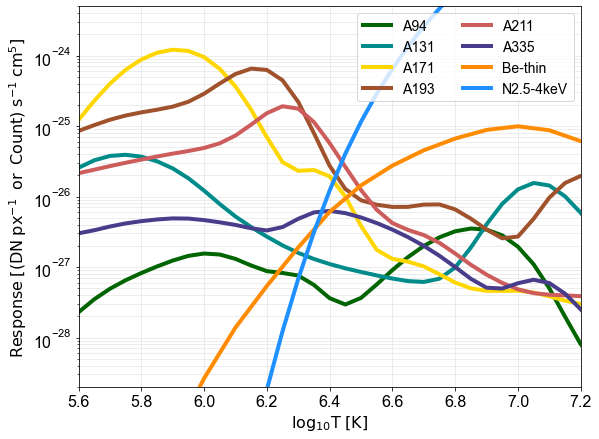

In [17]:
# Plot all the temperature responses
# Setup some colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue','darkorange','dodgerblue']

# Do the plot
fig = plt.figure(figsize=(9, 7))
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
for i in np.arange(8):
    plt.semilogy(tresp_logt,fin_tresp[:,i],label=chans[i],color=clrs[i],lw=4)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{Response\;[(DN\;px^{-1}\;\;or\;\;Count)\;s^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([5.6,7.2])
plt.legend(ncol=2,prop={'size': 14})
plt.rcParams.update({'font.size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
plt.show()

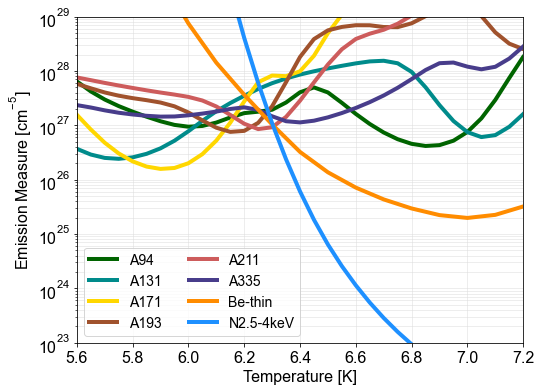

In [18]:
# Finally plot the EM Loci
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
fig = plt.figure(figsize=(8, 6))
for i in np.arange(8):
    plt.semilogy(tresp_logt,fin_dn[i]/fin_tresp[:,i],label=chans[i],color=clrs[i],lw=4)
plt.ylim([1e23,1e29])
plt.xlim([5.6,7.2])
plt.xlabel('Temperature [K]')
plt.ylabel('$Emission\;Measure\;[cm^{-5}]$')
plt.legend(ncol=2,prop={'size': 14})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
fig.show()

chisq [6.5]:  4.624034714875075
dn_reg/dn_in [6.5]:  [0.46356077 0.56610573 0.94128282 0.55931652 0.55625212 0.45749612
 0.44021715 1.04450829]
chisq [6.8]:  24.128528089783963
dn_reg/dn_in [6.8]:  [6.08550251e-07 4.71389332e-07 8.04966323e-07 3.53636691e-07
 3.69652850e-07 5.00362811e-07 5.58606642e-06 7.45092849e-04]


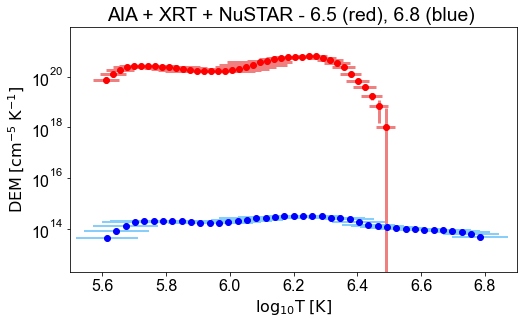

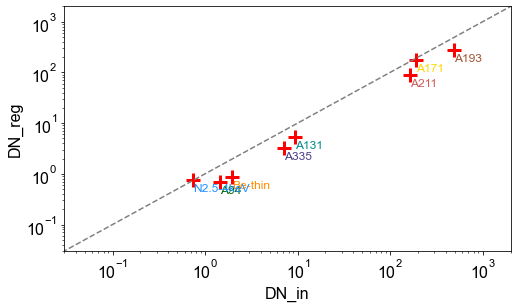

In [19]:
# DEM using AIA, XRT, NuSTAR over 5.6-6.8
temps=np.logspace(5.6,6.8,num=42)
dt=([temps[i+1]-temps[i] for i in np.arange(0,len(temps)-1)])
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])
dem68,edem68,elogt68,chisq68,dn_reg68\
    =dn2dem_pos(fin_dn,fin_edn,fin_tresp,tresp_logt,temps,gloci=1)
#####################################
# DEM using AIA, XRT, NuSTAR over 5.6-6.5
temps2=np.logspace(5.6,6.5,num=42)
dt2=([temps2[i+1]-temps2[i] for i in np.arange(0,len(temps2)-1)])
mlogt2=([np.mean([(np.log10(temps2[i])),np.log10((temps2[i+1]))]) \
        for i in np.arange(0,len(temps2)-1)])
dem65,edem65,elogt65,chisq65,dn_reg65\
    =dn2dem_pos(fin_dn,fin_edn,fin_tresp,tresp_logt,temps2,gloci=1)
#####################################
# Print and plot the results
print('chisq [6.5]: ',chisq65)
print('dn_reg/dn_in [6.5]: ',dn_reg65/fin_dn)
print('chisq [6.8]: ',chisq68)
print('dn_reg/dn_in [6.8]: ',dn_reg68/fin_dn)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt2,dem65,xerr=elogt65,yerr=edem65,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0)
plt.errorbar(mlogt,dem68,xerr=elogt68,yerr=edem68,fmt='ob',\
             ecolor='lightskyblue', elinewidth=2, capsize=0)
plt.title('AIA + XRT + NuSTAR - 6.5 (red), 6.8 (blue) ')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e12,9e21])
plt.xlim([5.5,6.9])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig,ax = plt.subplots(figsize=(8, 4.5))
plt.scatter(fin_dn,dn_reg65,color='red',marker='+',s=200,lw=3)
plt.scatter(fin_dn,dn_reg68,color='blue',marker='x',s=200,lw=3)
for i, lab in enumerate(chans):
    ax.annotate(lab, (fin_dn[i], 0.6*dn_reg65[i]),color=clrs[i],fontsize=12)
plt.plot([1e-2,1e4],[1e-2,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([3e-2,2e3])
plt.xlim([3e-2,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.show()

#  Fuller T range here really not doing well....... due to NuSTAR being very noisy?

---
#### Compare AIA+XRT vs AIA+XRT+NuSTAR

chisq [6.5 AXN]:  4.624034714875075
dn_reg/dn_in [6.5 AXN]:  [0.46356077 0.56610573 0.94128282 0.55931652 0.55625212 0.45749612
 0.44021715 1.04450829]
chisq [6.5 AX]:  0.7659496595963236
dn_reg/dn_in [6.5 AX]:  [0.70330228 0.80230093 1.11213782 0.87984339 0.9201422  0.76813352
 1.01412841]


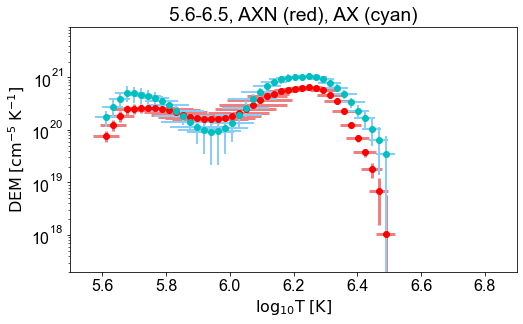

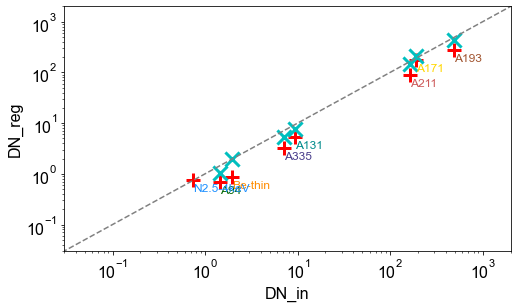

In [20]:
#####################################
# DEM using just AIA, XRT over 5.6-6.5
dem65ax,edem65ax,elogt65ax,chisq65ax,dn_reg65ax\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps2,gloci=1)
#####################################
# Print and plot the results
print('chisq [6.5 AXN]: ',chisq65)
print('dn_reg/dn_in [6.5 AXN]: ',dn_reg65/fin_dn)
print('chisq [6.5 AX]: ',chisq65ax)
print('dn_reg/dn_in [6.5 AX]: ',dn_reg65ax/dn_in)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt2,dem65,xerr=elogt65,yerr=edem65,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0)
plt.errorbar(mlogt2,dem65ax,xerr=elogt65ax,yerr=edem65ax,fmt='oc',\
             ecolor='lightskyblue', elinewidth=2, capsize=0)
plt.title('5.6-6.5, AXN (red), AX (cyan)')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim([5.5,6.9])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig,ax = plt.subplots(figsize=(8, 4.5))
plt.scatter(fin_dn,dn_reg65,color='red',marker='+',s=200,lw=3)
plt.scatter(dn_in,dn_reg65ax,color='c',marker='x',s=200,lw=3)
for i, lab in enumerate(chans):
    ax.annotate(lab, (fin_dn[i], 0.6*dn_reg65[i]),color=clrs[i],fontsize=12)
plt.plot([1e-2,1e4],[1e-2,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([3e-2,2e3])
plt.xlim([3e-2,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.show()


In [21]:
# Test the NuSTAR rate the AX DEM gives back
# nstint here is the NS temperature responses in same T binning as DEM, 
# and in units of [stuff * K] to get rid of dT in the DEM units
temps2=np.logspace(5.6,6.5,num=42)
dt2=([temps2[i+1]-temps2[i] for i in np.arange(0,len(temps2)-1)])
mlogt2=([np.mean([(np.log10(temps2[i])),np.log10((temps2[i+1]))]) \
        for i in np.arange(0,len(temps2)-1)])
dem65,edem65,elogt65,chisq65,dn_reg65\
    =dn2dem_pos(fin_dn,fin_edn,fin_tresp,tresp_logt,temps2,gloci=1)
nstint=10**np.interp(mlogt2,logt,np.log10(tresp[:,0]*area)) * dt2

rate_ax=np.vdot(nstint,dem65ax) # same as nstint.T @ dem66ax which is used in demmap_pos
# rate_axn=np.vdot(nstint,dem66)
# could equally do 
rate_axn=nstint.T @ dem65
print('NS Obs: ',"{0:.3f}".format(rate[0]),' count/s')
print('TR_N # DEM_AX: ', "{0:.3f}".format(rate_ax),' count/s')
print('TR_N # DEM_AXN: ', "{0:.3f}".format(rate_axn),' count/s')
#  Should be the same as above???
print('DN_REG_AXN (should be same as TR_N # DEM_AXN): ',"{0:.3f}".format(dn_reg65[7]),' count/s')

# This is consistent with the above DEMs:
# AIA+XRT+NuSTAR DEM gives a synthetic/regularised rate close to the observation
# AIA+XRT DEM not close as expected since DEMs different at higher Temps

NS Obs:  0.737  count/s
TR_N # DEM_AX:  3.214  count/s
TR_N # DEM_AXN:  0.770  count/s
DN_REG_AXN (should be same as TR_N # DEM_AXN):  0.770  count/s
